In [ ]:
%%capture
!pip install aif360
!pip install fairlearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


!cp drive/MyDrive/ORIE\ 5741/compas-scores-two-years.csv /usr/local/lib/python3.7/dist-packages/aif360/data/raw/compas

Mounted at /content/drive


In [ ]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'
%matplotlib inline

In [ ]:
PATH="drive/MyDrive/ORIE 5741/compas-scores-two-years.csv"

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

import pandas as pd

In [ ]:
raw=pd.read_csv(PATH,index_col=0)
raw.head(3)

,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1


In [ ]:
from aif360.sklearn.datasets import fetch_compas

In [ ]:
relevant=[
        # "race",
        "sex",
        # "age_cat",
        "juv_fel_count",
        "juv_misd_count",
        "juv_other_count",
        "priors_count",
        "c_charge_degree",
        "two_year_recid"
        ]

protected=[
        #    "race",
           "sex",
        #    "age_cat"
           ]

target=["two_year_recid"]

features=[i for i in relevant if i not in protected and i not in target]

In [ ]:
# load raw data
data=pd.read_csv(PATH,index_col=0)

# filter for relevant data
data=data.query("`r_charge_degree`!='(CO3)'")
data=data.loc[:,relevant]

# binarize protected features
# data=data.query("race=='African-American' | race=='Caucasian'")
# data.loc[:,"age_cat"]=data.age_cat.apply(lambda x: x if x=="Less than 25" else "Greater than 25")

# protected features set as index
data.reset_index(inplace=True)
data.set_index(["id"]+protected,drop=True,inplace=True)
X=data.loc[:,features]

y=1-data.two_year_recid

# encode charge degree
charge_degree_encoder=OneHotEncoder(categories=[["O","M","F"]])
X[["c_charge_degree=O","c_charge_degree=M","c_charge_degree=F"]]=charge_degree_encoder.fit_transform(X.loc[:,["c_charge_degree"]].values).todense()

# encode priors count into categorical values
X.loc[:,"priors_count"]=data.loc[:,"priors_count"].apply(lambda x: "0" if x==0 else ("1-3" if x<=3 else ">3"))
priors_count_encoder=OneHotEncoder(categories=[["0","1-3",">3"]])
X[["priors_count=0","priors_count=1-3","priors_count=>3"]]=priors_count_encoder.fit_transform(X.loc[:,["priors_count"]].values).todense()

X.drop(labels=["priors_count","c_charge_degree"],inplace=True,axis=1)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=1)

In [ ]:
X_train.head(3)

,,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree=O,c_charge_degree=M,c_charge_degree=F,priors_count=0,priors_count=1-3,priors_count=>3
id,sex,,,,,,,,,
3816,Male,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0
3415,Male,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0
2201,Female,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0


# Pre-Processing

In [ ]:
import numpy as np

In [ ]:
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

In [ ]:
protected_attribute_used = "race"

privileged_groups = [{protected_attribute_used: 1}]
unprivileged_groups = [{protected_attribute_used: 0}]
dataset_orig = load_preproc_data_compas([protected_attribute_used])
    
optim_options = {
    "distortion_fun": get_distortion_compas,
    "epsilon": 0.05,
    "clist": [0.99, 1.99, 2.99],
    "dlist": [.1, 0.05, 0]
}

#random seed
np.random.seed(1)

# Split into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [ ]:
OP = OptimPreproc(OptTools, optim_options)

OP = OP.fit(dataset_orig_train)

Optimized Preprocessing: Objective converged to 0.000000


In [ ]:
dataset_transf_train = OP.transform(dataset_orig_train, transform_Y=True)
dataset_transf_train = dataset_orig_train.align_datasets(dataset_transf_train)

In [ ]:
dataset_transf_test = OP.transform(dataset_orig_test, transform_Y = True)
dataset_transf_test = dataset_orig_test.align_datasets(dataset_transf_test)

## train LR on original dataset

In [ ]:
# Logistic regression classifier and predictions
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()

lr = LogisticRegression(penalty="l1",solver="liblinear")

lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)

# positive class index
pos_ind = np.where(lr.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_train_pred.labels = y_train_pred.reshape(-1,1)
dataset_orig_train_pred.scores = lr.predict_proba(X_train)[:,pos_ind].reshape(-1,1)


# eval
X_test = dataset_orig_test.features
y_test = dataset_orig_test.labels.ravel()

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
dataset_orig_test_pred.labels = lr.predict(X_test).reshape(-1,1)
dataset_orig_test_pred.scores = lr.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

fpr_lr,tpr_lr,_=roc_curve(y_test,lr.predict_proba(X_test)[:,1])
roc_auc_lr=auc(fpr_lr,tpr_lr)

## train boosting model on original dataset

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()

adb = AdaBoostClassifier()

adb.fit(X_train, y_train)
y_train_pred = adb.predict(X_train)

# positive class index
pos_ind = np.where(adb.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred_adb = dataset_orig_train.copy(deepcopy=True)
dataset_orig_train_pred_adb.labels = y_train_pred.reshape(-1,1)
dataset_orig_train_pred_adb.scores = adb.predict_proba(X_train)[:,pos_ind].reshape(-1,1)


# eval
X_test = dataset_orig_test.features
y_test = dataset_orig_test.labels.ravel()

dataset_orig_test_pred_adb = dataset_orig_test.copy(deepcopy=True)
dataset_orig_test_pred_adb.labels = adb.predict(X_test).reshape(-1,1)
dataset_orig_test_pred_adb.scores = adb.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

fpr_adb,tpr_adb,_=roc_curve(y_test,adb.predict_proba(X_test)[:,1])
roc_auc_adb=auc(fpr_adb,tpr_adb)

## train LR on transformed dataset

In [ ]:
# Logistic regression classifier and predictions
X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()

lr_transformed = LogisticRegression(penalty="l1",solver="liblinear")

lr_transformed.fit(X_train, y_train)
y_train_pred = lr_transformed.predict(X_train)

# positive class index
pos_ind = np.where(lr_transformed.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_transf_train_pred = dataset_transf_train.copy(deepcopy=True)
dataset_transf_train_pred.labels = y_train_pred.reshape(-1,1)
dataset_transf_train_pred.scores = lr_transformed.predict_proba(X_train)[:,pos_ind].reshape(-1,1)

# eval
X_test = dataset_transf_test.features
y_test = dataset_transf_test.labels.ravel()

dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)
dataset_transf_test_pred.labels = lr_transformed.predict(X_test).reshape(-1,1)
dataset_transf_test_pred.scores = lr_transformed.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

fpr_lr_t,tpr_lr_t,_=roc_curve(y_test,lr_transformed.predict_proba(X_test)[:,1])
roc_auc_lr_t=auc(fpr_lr_t,tpr_lr_t)

## train boosting classifier on transformed dataset

In [ ]:
X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()

adb_transformed = AdaBoostClassifier()

adb_transformed.fit(X_train, y_train)
y_train_pred = adb.predict(X_train)

# positive class index
pos_ind = np.where(adb_transformed.classes_ == dataset_transf_train.favorable_label)[0][0]

dataset_transf_train_pred_adb = dataset_transf_train.copy(deepcopy=True)
dataset_transf_train_pred_adb.labels = y_train_pred.reshape(-1,1)
dataset_transf_train_pred_adb.scores = adb.predict_proba(X_train)[:,pos_ind].reshape(-1,1)


# eval
X_test = dataset_transf_test.features
y_test = dataset_transf_test.labels.ravel()

dataset_transf_test_pred_adb = dataset_transf_test.copy(deepcopy=True)
dataset_transf_test_pred_adb.labels = adb_transformed.predict(X_test).reshape(-1,1)
dataset_transf_test_pred_adb.scores = adb_transformed.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

fpr_adb_t,tpr_adb_t,_=roc_curve(y_test,adb_transformed.predict_proba(X_test)[:,1])
roc_auc_adb_t=auc(fpr_adb_t,tpr_adb_t)

## ROC computation for COMPAS based on Decile score

In [ ]:
Y=raw.loc[:,["decile_score","two_year_recid"]]
y_true=Y.iloc[:,1]
y_pred=Y.iloc[:,0]/10

fpr_compas,tpr_compas,_=roc_curve(y_true,y_pred)
roc_auc_compas=auc(fpr_compas,tpr_compas)

## ROC plot

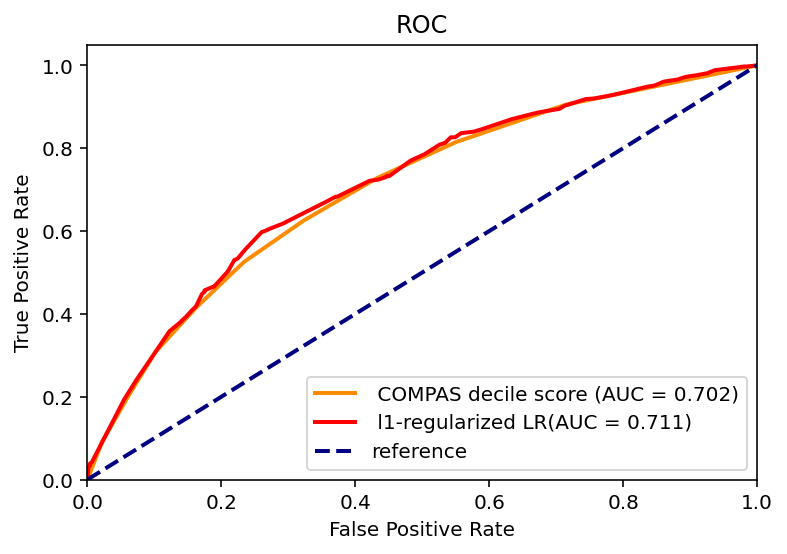

In [ ]:
plt.figure()
lw = 2

plt.plot(
    fpr_compas,
    tpr_compas,
    color="darkorange",
    lw=lw,
    label=" COMPAS decile score (AUC = %0.3f)" % roc_auc_compas,
)

plt.plot(
    fpr_lr,
    tpr_lr,
    color="red",
    lw=lw,
    label=" l1-regularized LR(AUC = %0.3f)" % roc_auc_lr,
)


plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--",label="reference")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

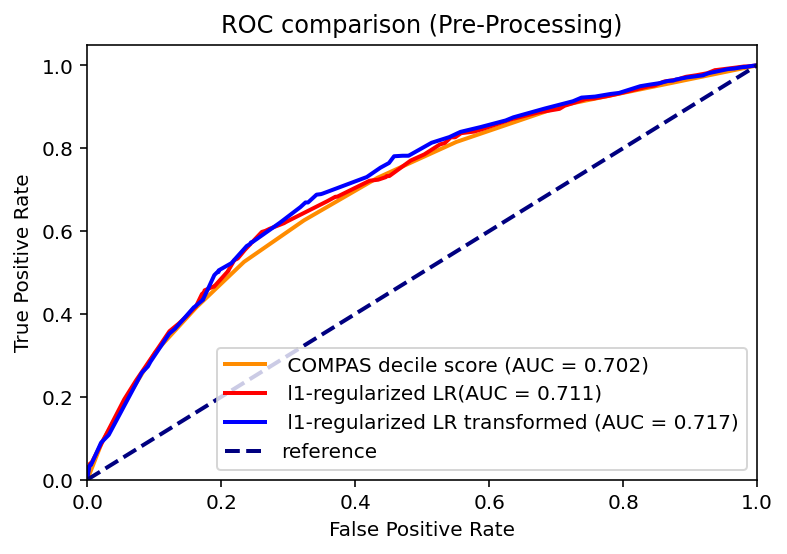

In [ ]:
plt.figure()
lw = 2

plt.plot(
    fpr_compas,
    tpr_compas,
    color="darkorange",
    lw=lw,
    label=" COMPAS decile score (AUC = %0.3f)" % roc_auc_compas,
)

plt.plot(
    fpr_lr,
    tpr_lr,
    color="red",
    lw=lw,
    label=" l1-regularized LR(AUC = %0.3f)" % roc_auc_lr,
)

plt.plot(
    fpr_lr_t,
    tpr_lr_t,
    color="blue",
    lw=lw,
    label=" l1-regularized LR transformed (AUC = %0.3f)" % roc_auc_lr_t,
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--",label="reference")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC comparison (Pre-Processing)")
plt.legend(loc="lower right")
plt.show()

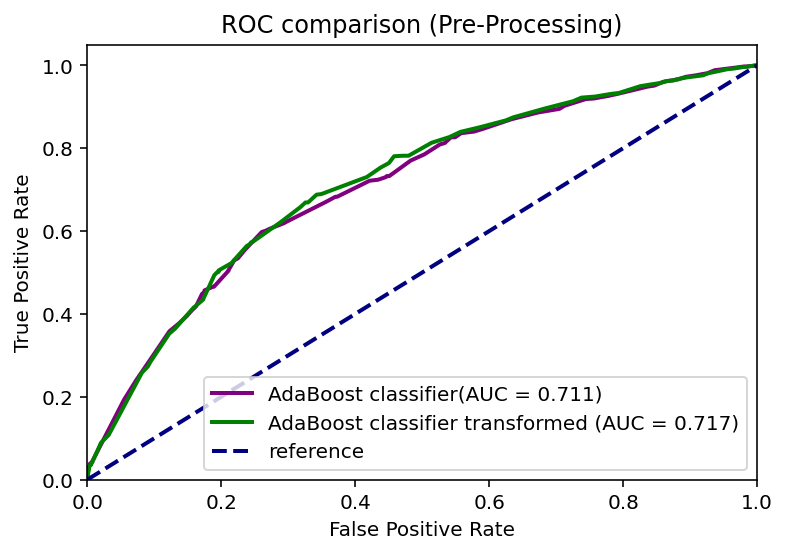

In [ ]:
plt.figure()
lw = 2


# plt.plot(
#     fpr_lr,
#     tpr_lr,
#     color="red",
#     lw=lw,
#     label=" l1-regularized LR(AUC = %0.3f)" % roc_auc_lr,
# )

# plt.plot(
#     fpr_lr_t,
#     tpr_lr_t,
#     color="blue",
#     lw=lw,
#     label=" l1-regularized LR transformed (AUC = %0.3f)" % roc_auc_lr_t,
# )

plt.plot(
    fpr_adb,
    tpr_adb,
    color="purple",
    lw=lw,
    label="AdaBoost classifier(AUC = %0.3f)" % roc_auc_adb,
)

plt.plot(
    fpr_adb_t,
    tpr_adb_t,
    color="green",
    lw=lw,
    label="AdaBoost classifier transformed (AUC = %0.3f)" % roc_auc_adb_t,
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--",label="reference")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC comparison (Pre-Processing)")
plt.legend(loc="lower right")
plt.show()

## Binary Label Dataset Metric evaluation

In [ ]:
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = -0.144854
Difference in mean outcomes between unprivileged and privileged groups = -0.062836


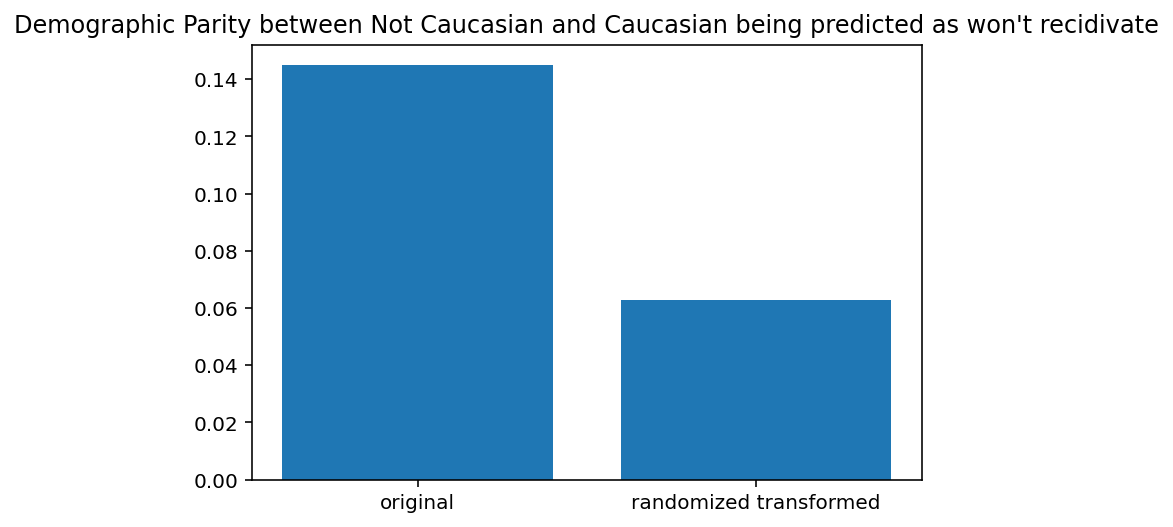

In [ ]:
plt.bar(["original","randomized transformed"],np.abs(np.array((metric_orig_test.mean_difference(),metric_transf_test.mean_difference()))))
plt.title("Demographic Parity between Not Caucasian and Caucasian being predicted as won't recidivate")
plt.show()

In [ ]:
# percentage of entries being altered during the preprocessing stage

1-np.mean((dataset_orig_test.convert_to_dataframe()[0]==dataset_transf_test.convert_to_dataframe()[0])).mean()

0.012626262626262652

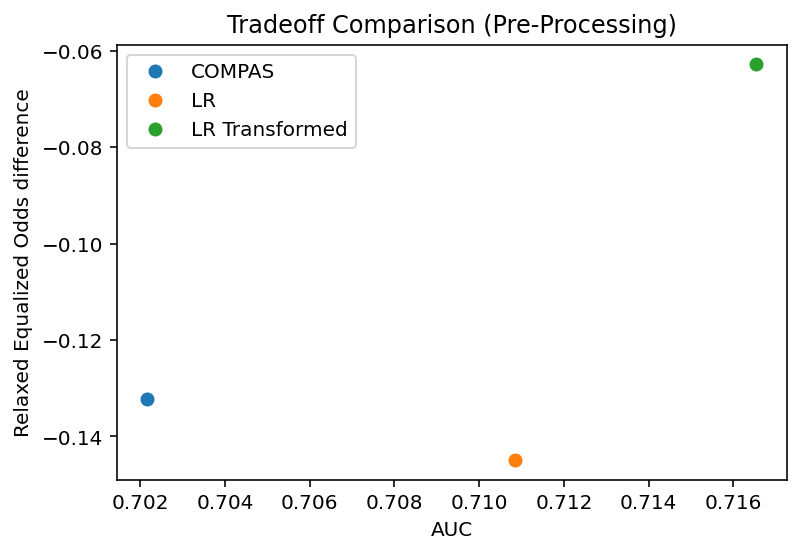

In [ ]:
metric_orig = BinaryLabelDatasetMetric(dataset_orig, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

plt.plot([roc_auc_compas],
         [metric_orig.mean_difference()],
         'o',label="COMPAS")
plt.plot([roc_auc_lr],
         [metric_orig_test.mean_difference()],
         'o',label="LR")
plt.plot([roc_auc_lr_t],
         [metric_transf_test.mean_difference()],
         'o',label="LR Transformed")
plt.xlabel("AUC")
plt.ylabel("Relaxed Equalized Odds difference")
plt.title("Tradeoff Comparison (Pre-Processing)")
plt.legend()
plt.show()

# Post-Processing

In [ ]:
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing

## calibrate dataset

In [ ]:
# dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
# dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

# dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

In [ ]:
# X_train = dataset_orig_train.features
# y_train = dataset_orig_train.labels.ravel()
# lr = LogisticRegression()
# lr.fit(X_train, y_train)

# fav_idx = np.where(lr.classes_ == dataset_orig_train.favorable_label)[0][0]
# y_train_pred_prob = lr.predict_proba(X_train)[:,fav_idx]

In [ ]:
# X_test = dataset_orig_test.features
# y_test_pred_prob = lr.predict_proba(X_test)[:,fav_idx]

In [ ]:
# class_thresh = 0.5

In [ ]:
# dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)
# dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)

# y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
# y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
# y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
# dataset_orig_train_pred.labels = y_train_pred

# y_test_pred = np.zeros_like(dataset_orig_test_pred.labels)
# y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_test_pred.favorable_label
# y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_test_pred.unfavorable_label
# dataset_orig_test_pred.labels = y_test_pred

In [ ]:
pp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint="weighted",
                                     seed=1)
pp = pp.fit(dataset_orig_train, dataset_orig_train_pred)

In [ ]:
dataset_calibrate_test_pred = pp.predict(dataset_orig_test_pred)

## clibrate for Adaboost

In [ ]:
pp_adb = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint="weighted",
                                     seed=1)
pp_adb = pp_adb.fit(dataset_orig_train, dataset_orig_train_pred_adb)

In [ ]:
dataset_calibrate_test_pred_adb = pp_adb.predict(dataset_orig_test_pred_adb)

## ROC plot

In [ ]:
# eval
y_test = dataset_orig_test.labels.ravel()
fpr_lr_c,tpr_lr_c,_=roc_curve(y_test,1-dataset_calibrate_test_pred.scores)
roc_auc_lr_c=auc(fpr_lr_c,tpr_lr_c)

In [ ]:
fpr_adb_c,tpr_adb_c,_=roc_curve(y_test,1-dataset_calibrate_test_pred_adb.scores)
roc_auc_adb_c=auc(fpr_adb_c,tpr_adb_c)

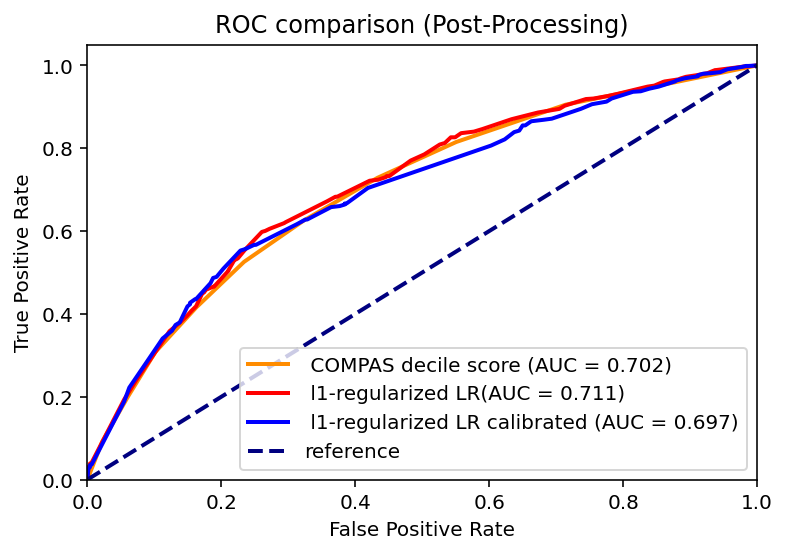

In [ ]:
plt.figure()
lw = 2

plt.plot(
    fpr_compas,
    tpr_compas,
    color="darkorange",
    lw=lw,
    label=" COMPAS decile score (AUC = %0.3f)" % roc_auc_compas,
)

plt.plot(
    fpr_lr,
    tpr_lr,
    color="red",
    lw=lw,
    label=" l1-regularized LR(AUC = %0.3f)" % roc_auc_lr,
)

plt.plot(
    fpr_lr_c,
    tpr_lr_c,
    color="blue",
    lw=lw,
    label=" l1-regularized LR calibrated (AUC = %0.3f)" % roc_auc_lr_c,
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--",label="reference")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC comparison (Post-Processing)")
plt.legend(loc="lower right")
plt.show()

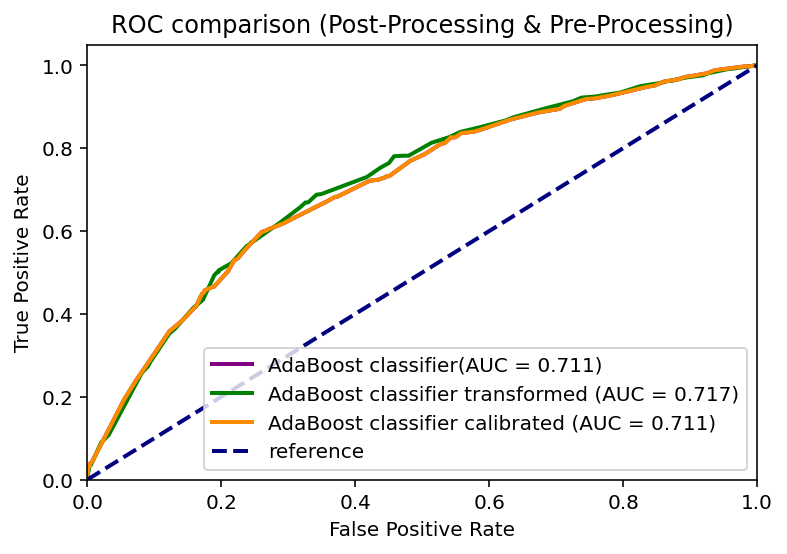

In [ ]:
plt.figure()
lw = 2


# plt.plot(
#     fpr_lr,
#     tpr_lr,
#     color="red",
#     lw=lw,
#     label=" l1-regularized LR(AUC = %0.3f)" % roc_auc_lr,
# )

# plt.plot(
#     fpr_lr_t,
#     tpr_lr_t,
#     color="blue",
#     lw=lw,
#     label=" l1-regularized LR transformed (AUC = %0.3f)" % roc_auc_lr_t,
# )

plt.plot(
    fpr_adb,
    tpr_adb,
    color="purple",
    lw=lw,
    label="AdaBoost classifier(AUC = %0.3f)" % roc_auc_adb,
)

plt.plot(
    fpr_adb_t,
    tpr_adb_t,
    color="green",
    lw=lw,
    label="AdaBoost classifier transformed (AUC = %0.3f)" % roc_auc_adb_t,
)

plt.plot(
    fpr_adb_c,
    tpr_adb_c,
    color="darkorange",
    lw=lw,
    label="AdaBoost classifier calibrated (AUC = %0.3f)" % roc_auc_adb_c,
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--",label="reference")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC comparison (Post-Processing & Pre-Processing)")
plt.legend(loc="lower right")
plt.show()

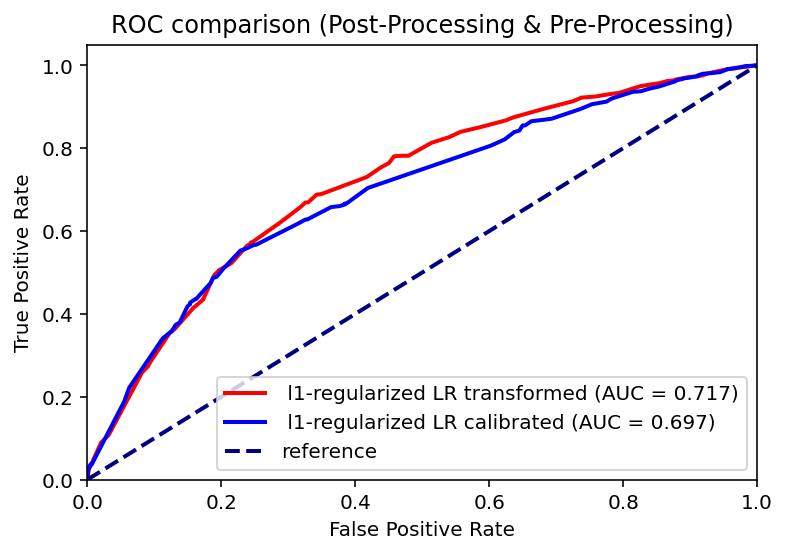

In [ ]:
plt.figure()
lw = 2

plt.plot(
    fpr_lr_t,
    tpr_lr_t,
    color="red",
    lw=lw,
    label=" l1-regularized LR transformed (AUC = %0.3f)" % roc_auc_lr_t,
)

plt.plot(
    fpr_lr_c,
    tpr_lr_c,
    color="blue",
    lw=lw,
    label=" l1-regularized LR calibrated (AUC = %0.3f)" % roc_auc_lr_c,
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--",label="reference")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC comparison (Post-Processing & Pre-Processing)")
plt.legend(loc="lower right")
plt.show()

## Classification Metric evaluation - Original dataset LR

In [ ]:
cm_original_test = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_original_test.difference(cm_original_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_original_test.difference(cm_original_test.generalized_false_negative_rate))

Difference in GFPR between unprivileged and privileged groups
-0.0957255925661773
Difference in GFNR between unprivileged and privileged groups
0.09831167870305196


In [ ]:
print(cm_original_test.generalized_false_positive_rate())

0.4817191026711931


In [ ]:
print(cm_original_test.generalized_false_negative_rate())

0.38485690811395934


## Orignal dataset Adaboost

In [ ]:
cm_original_test_adb = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred_adb,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)

## Classification Metric evaluation - Transformed dataset LR

In [ ]:
tmp=dataset_orig_test.copy(deepcopy=True)
tmp.scores=dataset_transf_test_pred.scores
tmp.labels=dataset_transf_test_pred.labels

In [ ]:
cm_transform_test = ClassificationMetric(dataset_orig_test, tmp,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transform_test.difference(cm_transform_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transform_test.difference(cm_transform_test.generalized_false_negative_rate))

Difference in GFPR between unprivileged and privileged groups
-0.027371362155623635
Difference in GFNR between unprivileged and privileged groups
0.03182223255391031


## transformed dataset Adaboost

In [ ]:
tmp3=dataset_orig_test.copy(deepcopy=True)
tmp3.scores=dataset_transf_test_pred_adb.scores
tmp3.labels=dataset_transf_test_pred_adb.labels

In [ ]:
cm_transform_test_adb = ClassificationMetric(dataset_orig_test, tmp3,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)

## Classification Metric evaluation - Original dataset Calibrated LR

In [ ]:
cm_calibrate_test = ClassificationMetric(dataset_orig_test, dataset_calibrate_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_calibrate_test.difference(cm_calibrate_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_calibrate_test.difference(cm_calibrate_test.generalized_false_negative_rate))

Difference in GFPR between unprivileged and privileged groups
-0.12043236843155625
Difference in GFNR between unprivileged and privileged groups
0.08383341793848947


In [ ]:
print(cm_calibrate_test.generalized_false_positive_rate())

0.48992384971262987


In [ ]:
print(cm_calibrate_test.generalized_false_negative_rate())

0.3916799965202474


## original dataset calibrated Adaboost

In [ ]:
cm_calibrate_test_adb = ClassificationMetric(dataset_orig_test, dataset_calibrate_test_pred_adb,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)

FNR

Equalized Odds

Diparate impact

demographic parity

individual fairness



In [ ]:
(
    cm_pred_test.disparate_impact(),
    cm_transf_test.disparate_impact()
)

NameError: ignored

In [ ]:
(
    cm_pred_test.average_abs_odds_difference(),
    cm_transf_test.average_abs_odds_difference()
)

In [ ]:
(
    cm_pred_test.binary_confusion_matrix(),
 cm_transf_test.binary_confusion_matrix()
 )

<hr>

# Combining Pre and Post process

In [ ]:
# dataset_both_train_pred = dataset_transf_train.copy(deepcopy=True)
# dataset_both_test_pred = dataset_transf_test.copy(deepcopy=True)

In [ ]:
# X_train = dataset_both_train_pred.features
# y_train = dataset_both_train_pred.labels.ravel()

# lr = LogisticRegression()
# lr.fit(X_train, y_train)

# fav_idx = np.where(lr.classes_ == dataset_transf_train.favorable_label)[0][0]
# y_train_pred_prob = lr.predict_proba(X_train)[:,fav_idx]

In [ ]:
# X_test = dataset_trans_test_pred.features
# y_test_pred_prob = lr.predict_proba(X_test)[:,fav_idx]

In [ ]:
# class_thresh = 0.5
# dataset_transf_train_pred.scores = y_train_pred_prob.reshape(-1,1)
# dataset_transf_test_pred.scores = y_test_pred_prob.reshape(-1,1)

# y_train_pred = np.zeros_like(dataset_transf_train_pred.labels)
# y_train_pred[y_train_pred_prob >= class_thresh] = dataset_transf_train_pred.favorable_label
# y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_transf_train_pred.unfavorable_label
# dataset_transf_train_pred.labels = y_train_pred

# y_test_pred = np.zeros_like(dataset_transf_test_pred.labels)
# y_test_pred[y_test_pred_prob >= class_thresh] = dataset_transf_test_pred.favorable_label
# y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_transf_test_pred.unfavorable_label
# dataset_transf_test_pred.labels = y_test_pred

In [ ]:
# pp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
#                                      unprivileged_groups = unprivileged_groups,
#                                      cost_constraint="weighted",
#                                      seed=1)
# pp = pp.fit(dataset_transf_train, dataset_transf_train_pred)

In [ ]:
# dataset_both_test_pred = pp.predict(dataset_transf_test_pred)

## calibrate transformed dataset

In [ ]:
pp_both = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint="weighted",
                                     seed=1)
pp_both = pp_both.fit(dataset_transf_train, dataset_transf_train_pred)

In [ ]:
dataset_both_test_pred = pp.predict(dataset_transf_test_pred)

## calibrate for Adaboost

In [ ]:
pp_both_adb = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint="weighted",
                                     seed=1)
pp_both_adb = pp_both_adb.fit(dataset_transf_train, dataset_transf_train_pred_adb)

In [ ]:
dataset_both_test_pred_adb = pp_both_adb.predict(dataset_transf_test_pred_adb)

## ROC plot

In [ ]:
# eval
y_test = dataset_transf_test.labels.ravel()
fpr_lr_b,tpr_lr_b,_=roc_curve(y_test,1-dataset_both_test_pred.scores)
roc_auc_lr_b=auc(fpr_lr_b,tpr_lr_b)

In [ ]:
fpr_adb_b,tpr_adb_b,_=roc_curve(y_test,1-dataset_both_test_pred_adb.scores)
roc_auc_adb_b=auc(fpr_adb_b,tpr_adb_b)

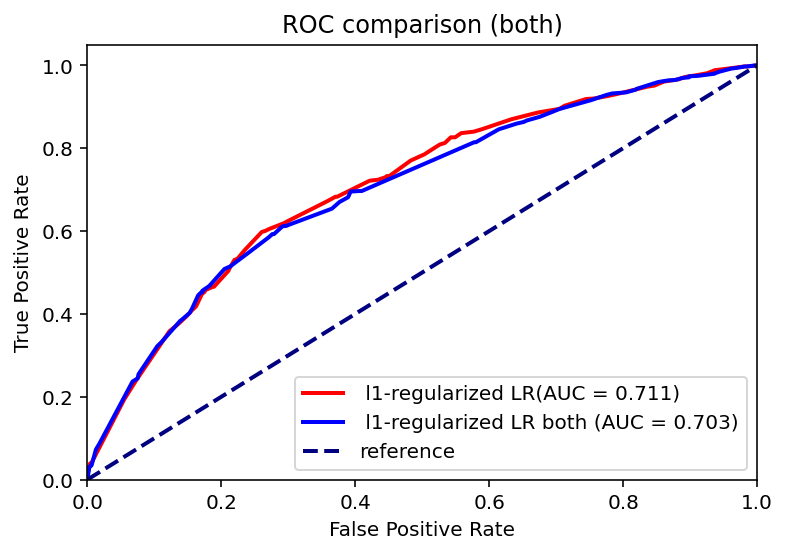

In [ ]:
plt.figure()
lw = 2

# plt.plot(
#     fpr_compas,
#     tpr_compas,
#     color="darkorange",
#     lw=lw,
#     label=" COMPAS decile score (AUC = %0.3f)" % roc_auc_compas,
# )

plt.plot(
    fpr_lr,
    tpr_lr,
    color="red",
    lw=lw,
    label=" l1-regularized LR(AUC = %0.3f)" % roc_auc_lr,
)

plt.plot(
    fpr_lr_b,
    tpr_lr_b,
    color="blue",
    lw=lw,
    label=" l1-regularized LR both (AUC = %0.3f)" % roc_auc_lr_b,
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--",label="reference")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC comparison (both)")
plt.legend(loc="lower right")
plt.show()

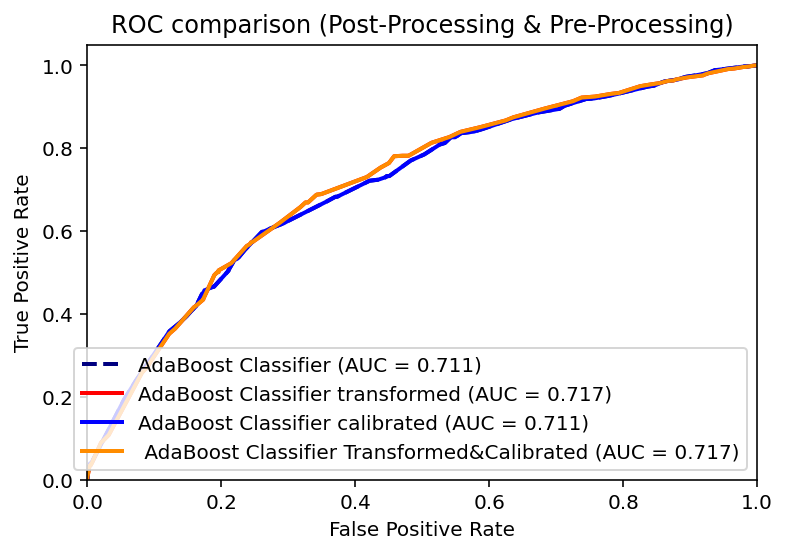

In [ ]:
plt.figure()
lw = 2

plt.plot(
    fpr_adb,
    tpr_adb,
    color="navy",
    lw=lw,
    linestyle="--",
    label="AdaBoost Classifier (AUC = %0.3f)" % roc_auc_adb,
)

plt.plot(
    fpr_adb_t,
    tpr_adb_t,
    color="red",
    lw=lw,
    label="AdaBoost Classifier transformed (AUC = %0.3f)" % roc_auc_adb_t,
)

plt.plot(
    fpr_adb_c,
    tpr_adb_c,
    color="blue",
    lw=lw,
    label="AdaBoost Classifier calibrated (AUC = %0.3f)" % roc_auc_adb_c,
)

plt.plot(
    fpr_adb_b,
    tpr_adb_b,
    color="darkorange",
    lw=lw,
    label=" AdaBoost Classifier Transformed&Calibrated (AUC = %0.3f)" % roc_auc_adb_b,
)

# plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--",label="reference")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC comparison (Post-Processing & Pre-Processing)")
plt.legend(loc="lower right")
plt.show()

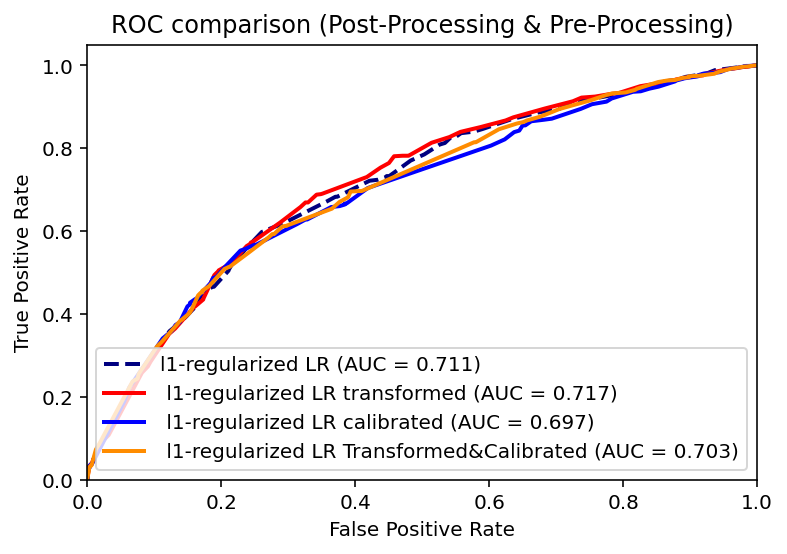

In [ ]:
plt.figure()
lw = 2

plt.plot(
    fpr_lr,
    tpr_lr,
    color="navy",
    lw=lw,
    linestyle="--",
    label="l1-regularized LR (AUC = %0.3f)" % roc_auc_lr,
)


plt.plot(
    fpr_lr_t,
    tpr_lr_t,
    color="red",
    lw=lw,
    label=" l1-regularized LR transformed (AUC = %0.3f)" % roc_auc_lr_t,
)

plt.plot(
    fpr_lr_c,
    tpr_lr_c,
    color="blue",
    lw=lw,
    label=" l1-regularized LR calibrated (AUC = %0.3f)" % roc_auc_lr_c,
)

plt.plot(
    fpr_lr_b,
    tpr_lr_b,
    color="darkorange",
    lw=lw,
    label=" l1-regularized LR Transformed&Calibrated (AUC = %0.3f)" % roc_auc_lr_b,
)

# plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--",label="reference")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC comparison (Post-Processing & Pre-Processing)")
plt.legend(loc="lower right")
plt.show()

## Classification Metric evaluation - Tranformed dataset Calibrated LR

In [ ]:
tmp2=dataset_orig_test.copy(deepcopy=True)
tmp2.scores=dataset_both_test_pred.scores
tmp2.labels=dataset_both_test_pred.labels

In [ ]:
cm_both_test = ClassificationMetric(dataset_orig_test, tmp2,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_both_test.difference(cm_both_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_both_test.difference(cm_both_test.generalized_false_negative_rate))

Difference in GFPR between unprivileged and privileged groups
-0.0669873264878515
Difference in GFNR between unprivileged and privileged groups
0.028596007023492187


## transformed dataset calibrated Adaboost

In [ ]:
tmp4=dataset_orig_test_pred_adb.copy(deepcopy=True)
tmp4.scores=dataset_both_test_pred_adb.scores
tmp4.labels=dataset_both_test_pred_adb.labels

In [ ]:
cm_both_test_adb = ClassificationMetric(dataset_orig_test, tmp4,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)

## Binary Label Dataset Metric evaluation

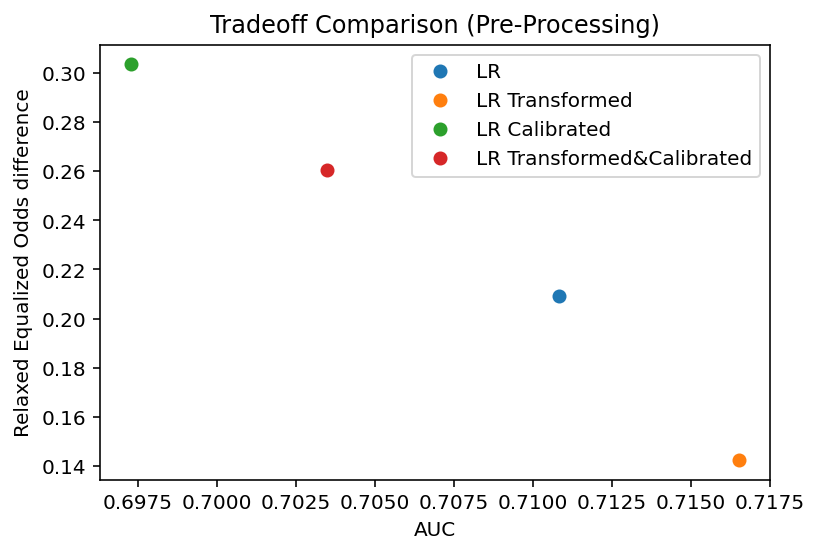

In [ ]:
metric_orig = BinaryLabelDatasetMetric(dataset_orig, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
metric_orig_test_pred = BinaryLabelDatasetMetric(dataset_orig_test_pred, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
metric_transf_test_pred = BinaryLabelDatasetMetric(dataset_transf_test_pred, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
metric_calibrate_test_pred = BinaryLabelDatasetMetric(dataset_calibrate_test_pred, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
metric_both_test_pred = BinaryLabelDatasetMetric(dataset_both_test_pred, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)


# plt.plot([roc_auc_compas],
#          [metric_orig.mean_difference()],
#          'o',label="COMPAS")
plt.plot([roc_auc_lr],
         [-metric_orig_test_pred.mean_difference()],
         'o',label="LR")
plt.plot([roc_auc_lr_t],
         [-metric_transf_test_pred.mean_difference()],
         'o',label="LR Transformed")
plt.plot([roc_auc_lr_c],
         [-metric_calibrate_test_pred.mean_difference()],
         'o',label="LR Calibrated")
plt.plot([roc_auc_lr_b],
         [-metric_both_test_pred.mean_difference()],
         'o',label="LR Transformed&Calibrated")

plt.xlabel("AUC")
plt.ylabel("Relaxed Equalized Odds difference")
plt.title("Tradeoff Comparison (Pre-Processing)")
plt.legend()
plt.show()

<hr>
<hr>

# accuracy comparison



In [ ]:
# metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
#                                          unprivileged_groups=unprivileged_groups,
#                                          privileged_groups=privileged_groups)
# metric_transf_test

In [ ]:
# np.mean(y_test==lr.predict(X_test))

In [ ]:
# np.mean(dataset_orig_test.labels.ravel()==lr.predict(dataset_orig_test.features))

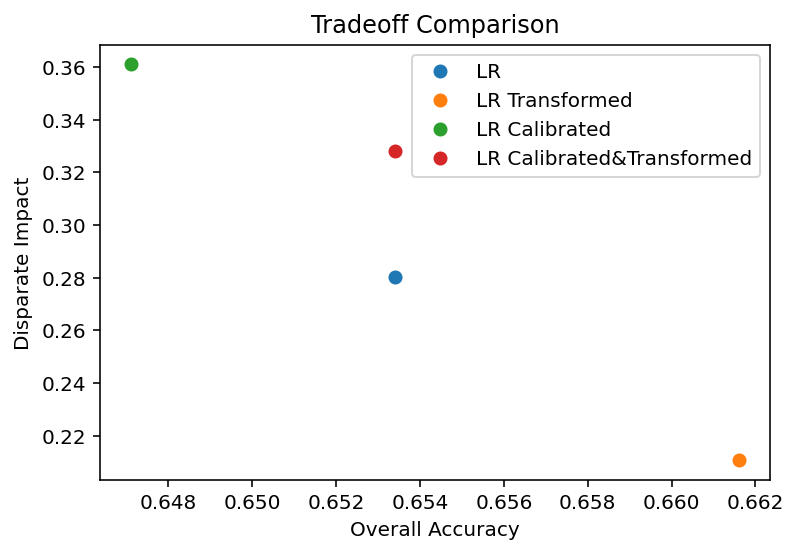

In [ ]:
fig, ax = plt.subplots()

ax.plot([np.mean(dataset_orig_test.labels.ravel()==lr.predict(dataset_orig_test.features))],
         [1-metric_orig_test_pred.disparate_impact()],
         'o',label="LR")
ax.plot([np.mean(dataset_orig_test.labels.ravel()==lr_transformed.predict(dataset_transf_test.features))],
         [1-metric_transf_test_pred.disparate_impact()],
         'o',label="LR Transformed")
ax.plot([np.mean(dataset_orig_test.labels==dataset_calibrate_test_pred.labels)],
         [1-metric_calibrate_test_pred.disparate_impact()],
         'o',label="LR Calibrated")
ax.plot([np.mean(dataset_orig_test.labels==dataset_both_test_pred.labels)],
         [1-metric_both_test_pred.disparate_impact()],
         'o',label="LR Calibrated&Transformed")

plt.xlabel("Overall Accuracy")
plt.ylabel("Disparate Impact")
plt.title("Tradeoff Comparison")
# ax.axhspan(0,0.2, alpha=0.2, color='red')
plt.legend()
plt.show()

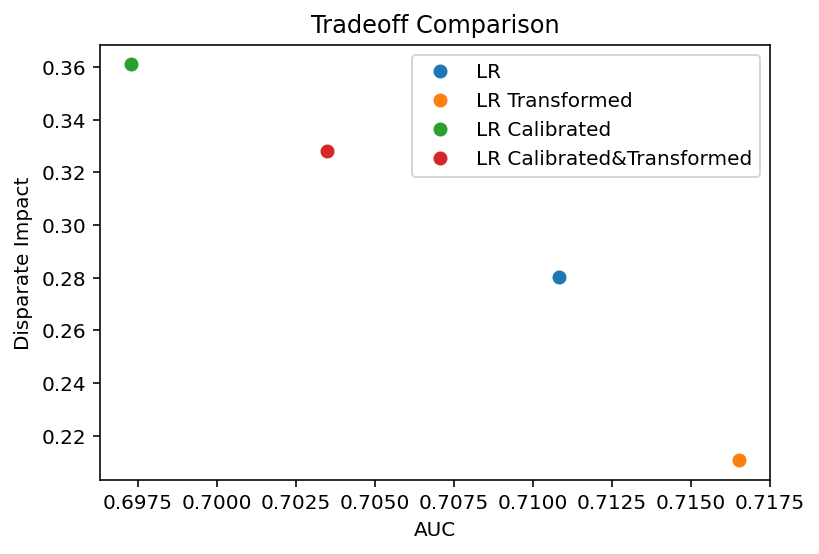

In [ ]:
fig, ax = plt.subplots()
ax.plot([roc_auc_lr],
         [1-metric_orig_test_pred.disparate_impact()],
         'o',label="LR")
ax.plot([roc_auc_lr_t],
         [1-metric_transf_test_pred.disparate_impact()],
         'o',label="LR Transformed")
ax.plot([roc_auc_lr_c],
         [1-metric_calibrate_test_pred.disparate_impact()],
         'o',label="LR Calibrated")
ax.plot([roc_auc_lr_b],
         [1-metric_both_test_pred.disparate_impact()],
         'o',label="LR Calibrated&Transformed")

plt.xlabel("AUC")
plt.ylabel("Disparate Impact")
# ax.axhspan(0,0.2, alpha=0.2, color='red')
plt.title("Tradeoff Comparison")
plt.legend()
plt.show()

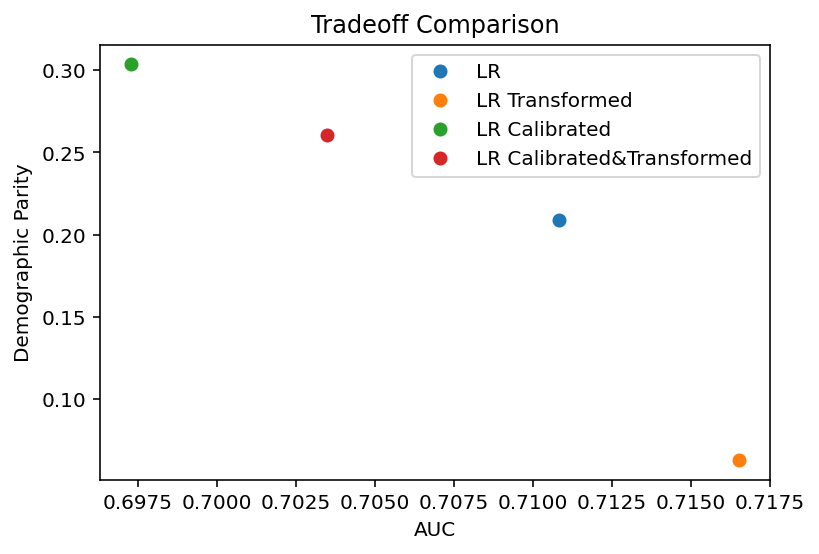

In [ ]:
plt.plot([roc_auc_lr],
         [-metric_orig_test_pred.mean_difference()],
         'o',label="LR")
plt.plot([roc_auc_lr_t],
         [-metric_transf_test.mean_difference()],
         'o',label="LR Transformed")
plt.plot([roc_auc_lr_c],
         [-metric_calibrate_test_pred.mean_difference()],
         'o',label="LR Calibrated")
plt.plot([roc_auc_lr_b],
         [-metric_both_test_pred.mean_difference()],
         'o',label="LR Calibrated&Transformed")

plt.xlabel("AUC")
plt.ylabel("Demographic Parity")
plt.title("Tradeoff Comparison")
plt.legend()
plt.show()

In [ ]:
# metric_calibrate_test=BinaryLabelDatasetMetric(dataset_calibrate_test_pred,
#                                    unprivileged_groups,
#                                    privileged_groups)
# metric_both_test=BinaryLabelDatasetMetric(dataset_both_test_pred,
#                                    unprivileged_groups,
#                                    privileged_groups)

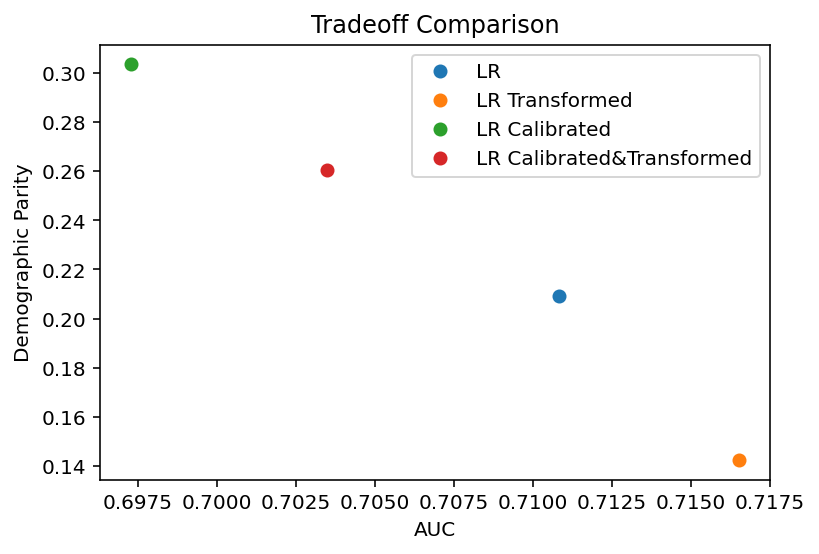

In [ ]:
plt.plot([roc_auc_lr],
         [-metric_orig_test_pred.difference(metric_orig_test_pred.base_rate)],
         'o',label="LR")
plt.plot([roc_auc_lr_t],
         [-metric_transf_test_pred.difference(metric_transf_test_pred.base_rate)],
         'o',label="LR Transformed")

plt.plot([roc_auc_lr_c],
         [-metric_calibrate_test_pred.difference(metric_calibrate_test_pred.base_rate)],
         'o',label="LR Calibrated")
plt.plot([roc_auc_lr_b],
         [-metric_both_test_pred.difference(metric_both_test_pred.base_rate)],
         'o',label="LR Calibrated&Transformed")

plt.xlabel("AUC")
plt.ylabel("Demographic Parity")
plt.title("Tradeoff Comparison")
plt.legend()
plt.show()

## GFNR and GFPR difference comparison plot

In [ ]:
cm_original_test.difference(cm_original_test.generalized_false_negative_rate)

0.09831167870305196

In [ ]:
cm_calibrate_test.difference(cm_calibrate_test.generalized_false_negative_rate)

0.08383341793848947

In [ ]:
cm_both_test.difference(cm_both_test.generalized_false_negative_rate)

0.028596007023492187

In [ ]:
cm_original_test.theil_index()

0.17177318932027258

In [ ]:
cm_transform_test.theil_index()

0.18307316806723367

In [ ]:
cm_calibrate_test.theil_index()

0.1555394294819415

In [ ]:
cm_both_test.theil_index()

0.1630825143333197

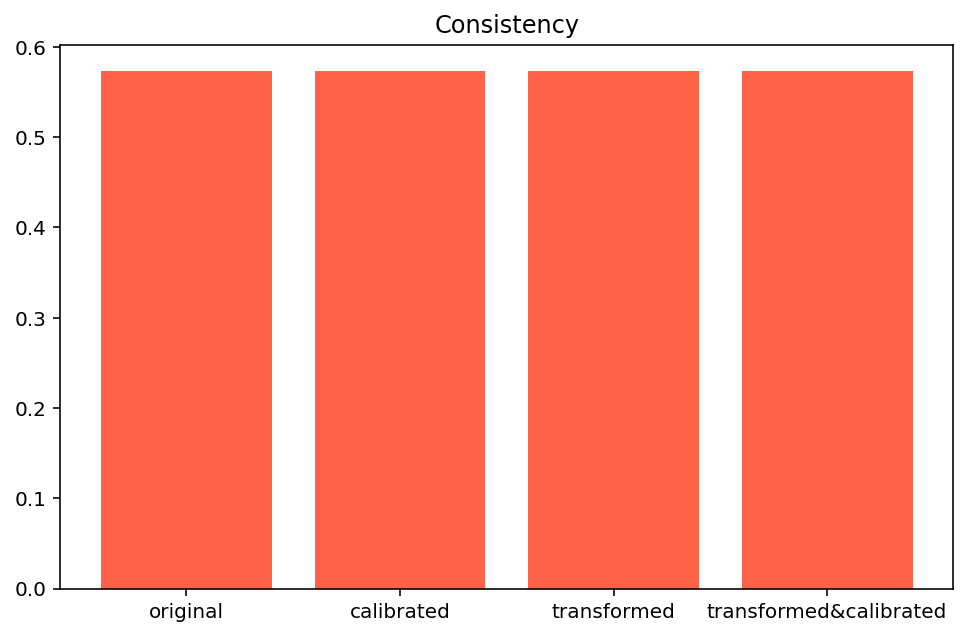

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(["original","calibrated","transformed","transformed&calibrated"],
        [cm_original_test.consistency()[0],
         cm_calibrate_test.consistency()[0],
         cm_transform_test.consistency()[0],
         cm_both_test.consistency()[0]],color="tomato")
plt.title("Consistency")
plt.show()

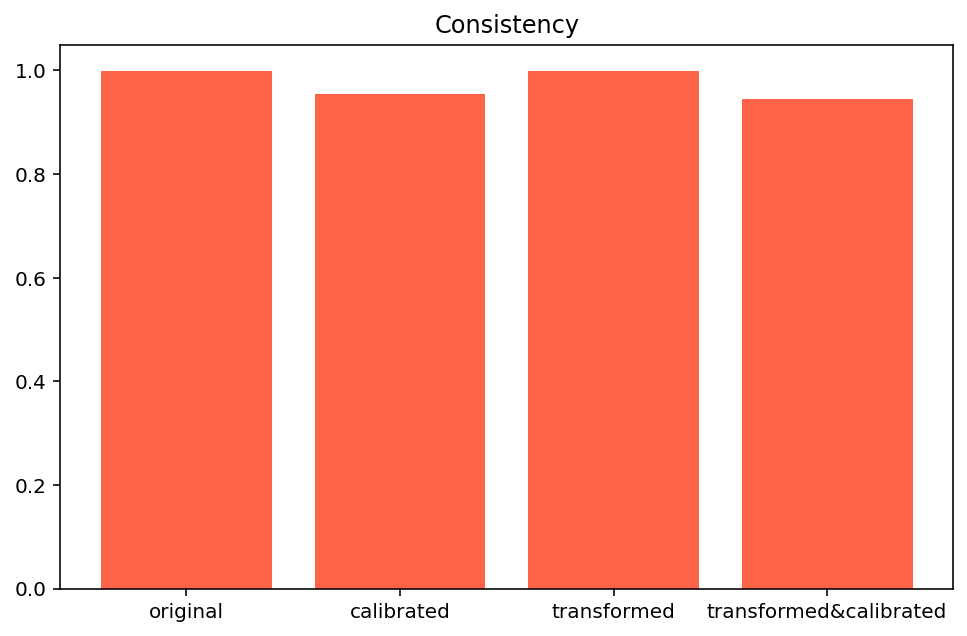

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(["original","calibrated","transformed","transformed&calibrated"],
        [metric_orig_test_pred.consistency()[0],
         metric_calibrate_test_pred.consistency()[0],
         metric_transf_test_pred.consistency()[0],
         metric_both_test_pred.consistency()[0]],color="tomato")
plt.title("Consistency")
plt.show()

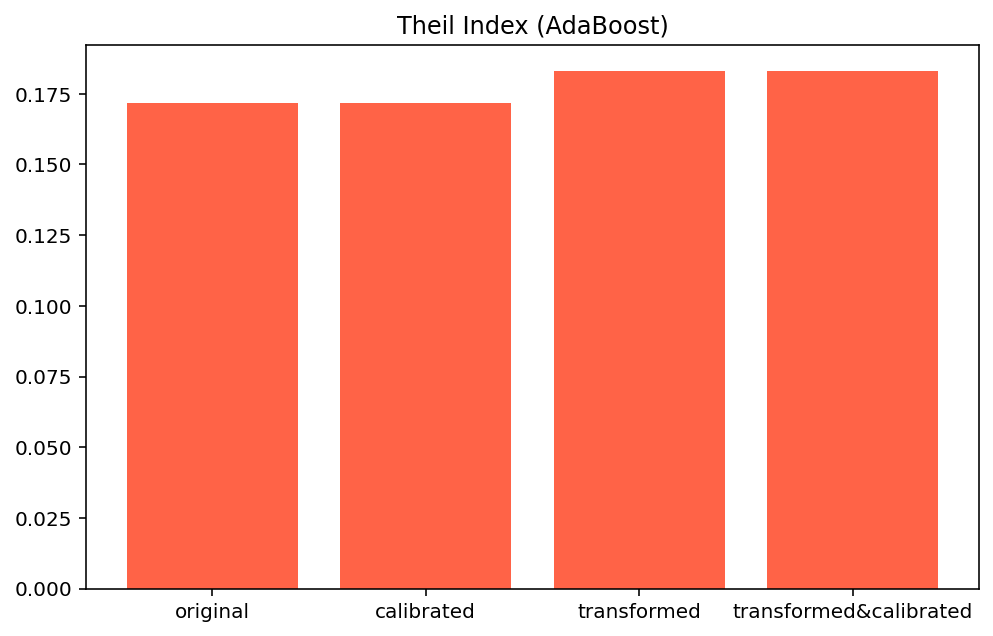

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(["original","calibrated","transformed","transformed&calibrated"],
        [cm_original_test_adb.theil_index(),
         cm_calibrate_test_adb.theil_index(),
         cm_transform_test_adb.theil_index(),
         cm_both_test_adb.theil_index()],color="tomato")
plt.title("Theil Index (AdaBoost)")
plt.show()

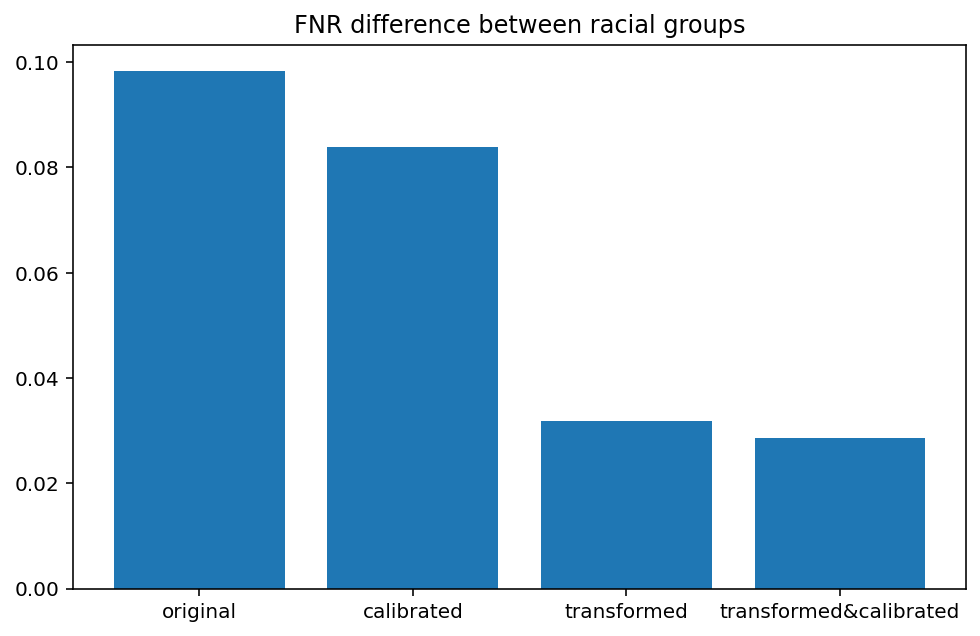

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(["original","calibrated","transformed","transformed&calibrated"],
        [cm_original_test.difference(cm_original_test.generalized_false_negative_rate),
         cm_calibrate_test.difference(cm_calibrate_test.generalized_false_negative_rate),
         cm_transform_test.difference(cm_transform_test.generalized_false_negative_rate),
         cm_both_test.difference(cm_both_test.generalized_false_negative_rate)])
plt.title("FNR difference between racial groups")
plt.show()

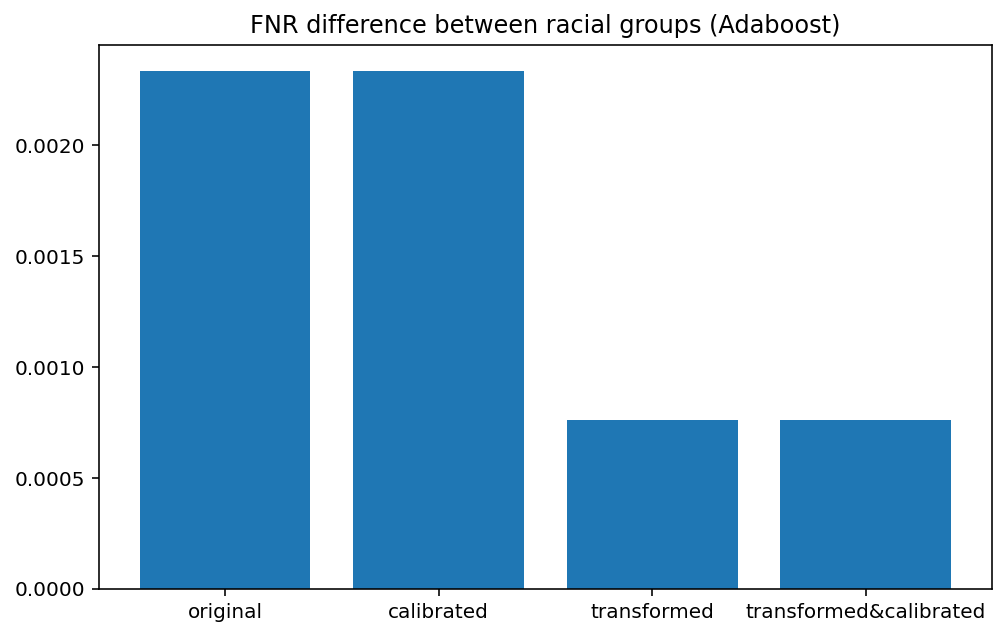

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(["original","calibrated","transformed","transformed&calibrated"],
        [cm_original_test_adb.difference(cm_original_test_adb.generalized_false_negative_rate),
         cm_calibrate_test_adb.difference(cm_calibrate_test_adb.generalized_false_negative_rate),
         cm_transform_test_adb.difference(cm_transform_test_adb.generalized_false_negative_rate),
         cm_both_test_adb.difference(cm_both_test_adb.generalized_false_negative_rate)])
plt.title("FNR difference between racial groups (Adaboost)")
plt.show()

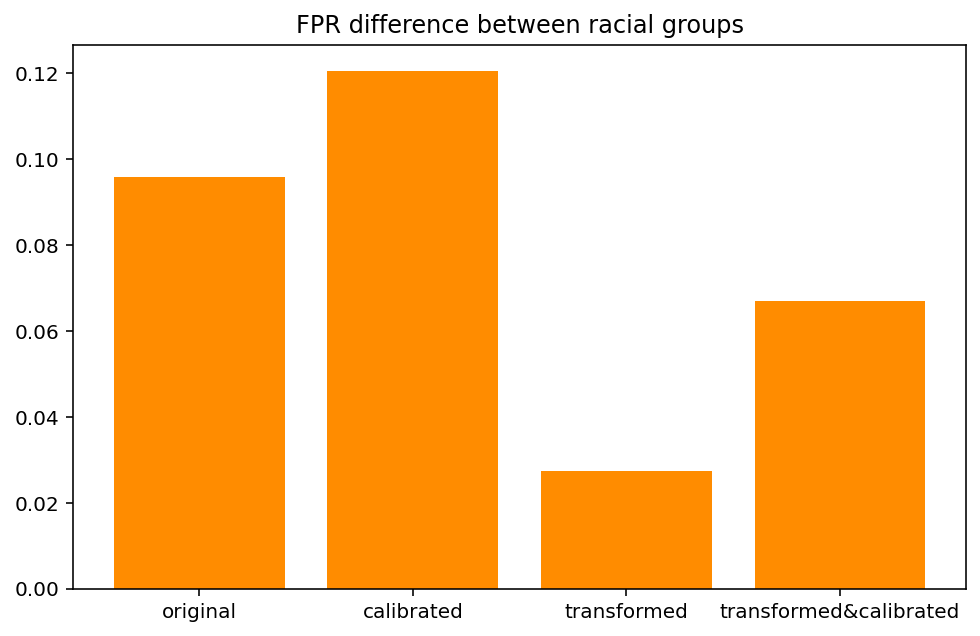

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(["original","calibrated","transformed","transformed&calibrated"],
        [-cm_original_test.difference(cm_original_test.generalized_false_positive_rate),
         -cm_calibrate_test.difference(cm_calibrate_test.generalized_false_positive_rate),
         -cm_transform_test.difference(cm_transform_test.generalized_false_positive_rate),
         -cm_both_test.difference(cm_both_test.generalized_false_positive_rate)],color='darkorange')
plt.title("FPR difference between racial groups")
plt.show()

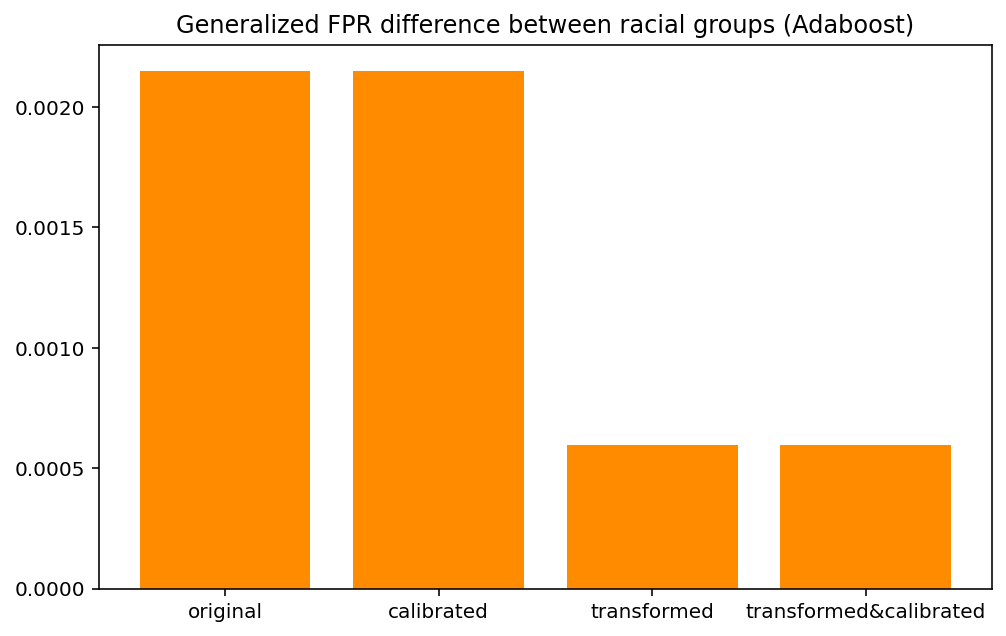

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(["original","calibrated","transformed","transformed&calibrated"],
        [-cm_original_test_adb.difference(cm_original_test_adb.generalized_false_positive_rate),
         -cm_calibrate_test_adb.difference(cm_calibrate_test_adb.generalized_false_positive_rate),
         -cm_transform_test_adb.difference(cm_transform_test_adb.generalized_false_positive_rate),
         -cm_both_test_adb.difference(cm_both_test_adb.generalized_false_positive_rate)],color='darkorange')
plt.title("Generalized FPR difference between racial groups (Adaboost)")
plt.show()

## overall GFNR, GFPR comparison plot

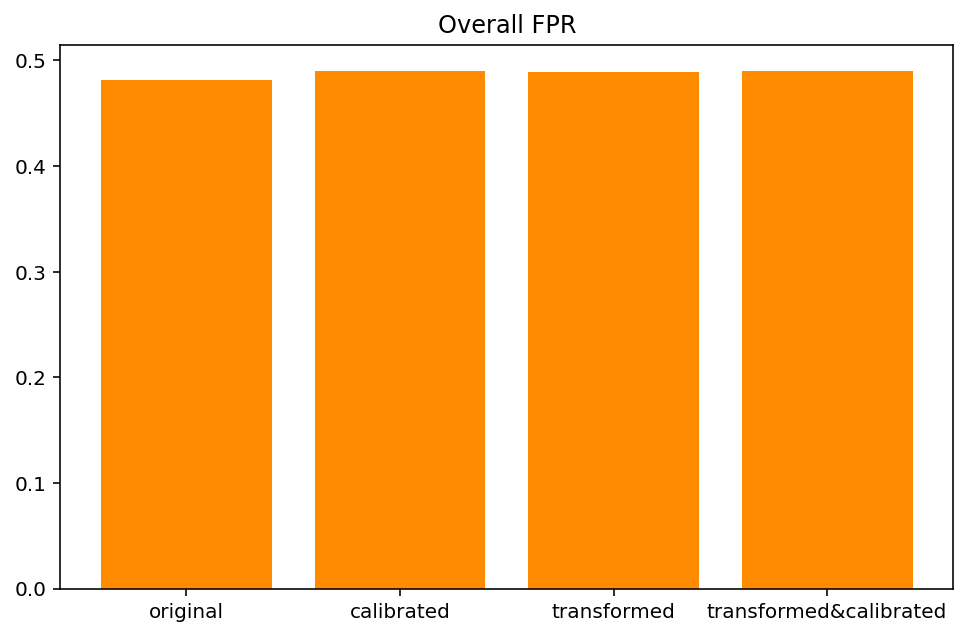

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(["original","calibrated","transformed","transformed&calibrated"],
        [(cm_original_test.generalized_false_positive_rate()),
         (cm_calibrate_test.generalized_false_positive_rate()),
         (cm_transf_test.generalized_false_positive_rate()),
         (cm_both_test.generalized_false_positive_rate())],color='darkorange')
plt.title("Overall FPR")
plt.show()

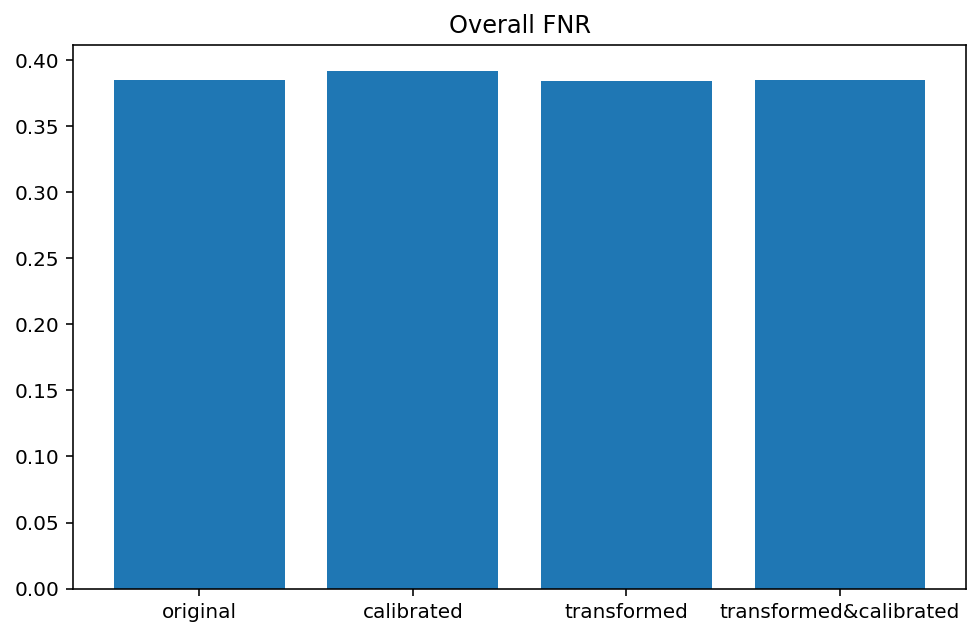

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(["original","calibrated","transformed","transformed&calibrated"],
        [(cm_original_test.generalized_false_negative_rate()),
         (cm_calibrate_test.generalized_false_negative_rate()),
         (cm_transf_test.generalized_false_negative_rate()),
         (cm_both_test.generalized_false_negative_rate())])
plt.title("Overall FNR")
plt.show()

In [ ]:
fnr=np.array([(cm_original_test.generalized_false_negative_rate()),
         (cm_calibrate_test.generalized_false_negative_rate()),
         (cm_transf_test.generalized_false_negative_rate()),
         (cm_both_test.generalized_false_negative_rate())])
fnr=(fnr-fnr.min())/(fnr.max())

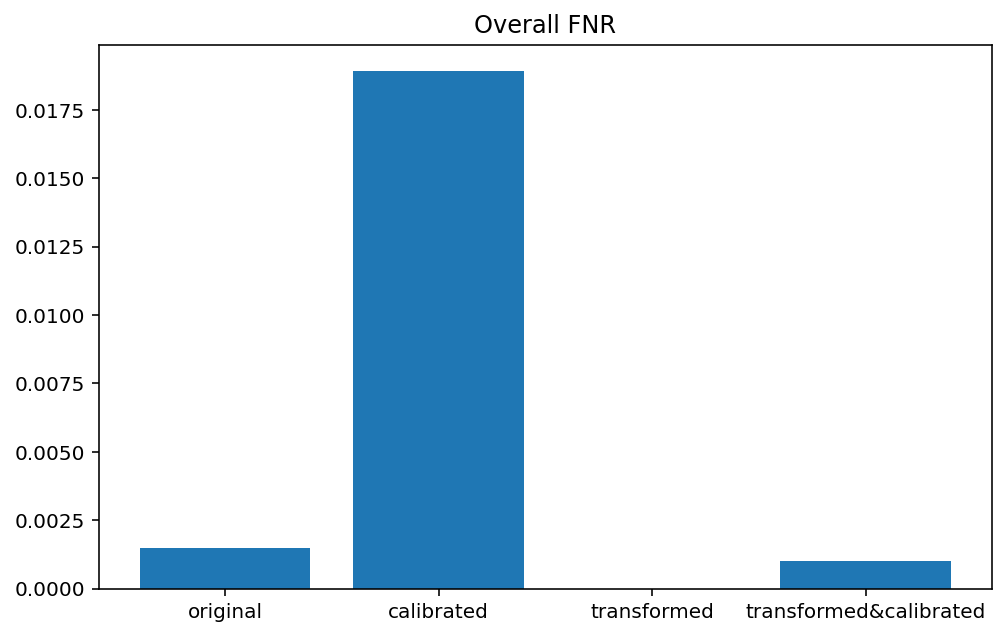

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(["original","calibrated","transformed","transformed&calibrated"],
        fnr)
plt.title("Overall FNR")
plt.show()